In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
step = 1
train_start = np.arange(1948,1977,step)
#train_end = np.arange(1955,2006,step)
validation_end = np.arange(1982,2011,step)
test_start = np.arange(1983,2012,step)
test_end = np.arange(1987,2016,step)

In [4]:
n_components_sst = np.load("sst_number.npy")
n_components_soil = np.load("soil_number.npy")
f = 12
taus = np.arange(1,13,1)
#taus = np.arange(5,0,-1)
cc = 'ET'
level = 99
model_type = 'corr'
extremes_treshold = -1

In [22]:
temporal_limits = {"time_min":datetime(train_start[0], 1, 1, 0, 0),"time_max":datetime(validation_end[0], 12, 1, 0, 0)}
data_sst, ts, V, df_sst, lon_sst, lat_sst = ff.PCA_computer_rotated_locs('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst[0], -9.96921e+36)
temporal_limits = {"time_min":datetime(train_start[0], 1, 1, 0, 0),"time_max":datetime(test_end[0], 12, 1, 0, 0)}
data_soil, ts_soil, V_soil, df_soil, INDEX, lon_soil, lat_soil= PCA_soil_rotated_locs('../../../nc/soilw.mon.mean.v2.nc', "soilw",temporal_limits, n_components_soil[0], test_n = test_end[0] - validation_end[0],missing_value= 0)

In [23]:
lon1_soil = np.arange(-179.75,180,2)
lon1_sst = np.arange(-180,180,2)

In [44]:
for tau in taus:
    deg_sst = np.zeros((len(lat_sst),len(lon1_sst)))
    deg_soil = np.zeros((len(lat_soil),len(lon1_soil)))
    for ijz in range(len(train_start)):
        
        temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
        data_sst, ts, V, df_sst, _, _ = ff.PCA_computer_rotated_locs('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst[ijz], -9.96921e+36)
        temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(test_end[ijz], 12, 1, 0, 0)}
        data_soil, ts_soil, V_soil, df_soil, INDEX, _, _= PCA_soil_rotated_locs('../../../nc/soilw.mon.mean.v2.nc', "soilw",temporal_limits, n_components_soil[ijz], test_n = test_end[ijz] - validation_end[ijz],missing_value= 0)
        
        link = np.load("../../whole_data_results/ET_orac/best_link_hybrid_{}/{}_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),model_type,f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))
        link_name = np.load("../../whole_data_results/ET_orac/best_link_hybrid_{}/{}_name_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),model_type,f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))
        if len(link) == 0 : continue
        
        comps_sst = []
        comps_soil = []
        for k in range(len(link_name)):
            if link_name[k] == 'sst':
                comps_sst.append(link[k,0])
            else:
                comps_soil.append(link[k,0])

        for comp in set(comps_sst):
            deg = np.zeros((len(lat_sst),len(lon1_sst)))
            df_sst["pc"] = V[:,comp-1]
            for i in range(len(lat_sst)):
                for j in range(len(lon1_sst)):
                    if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                        deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
                    else:
                        deg[i,j]=np.nan


            if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
                limit = np.nanpercentile(deg, 1 - level)
                deg[deg>=limit]=0
                deg[deg<limit]=1
            else:
                limit = np.nanpercentile(deg, level)
                deg[deg<=limit]=0
                deg[deg>limit]=1

            deg_sst = deg_sst + deg
            
            
        for comp in set(comps_soil):
            deg = np.zeros((len(lat_soil),len(lon1_soil)))
            df_soil["pc"] = V_soil[:,comp-1]
            for i in range(len(lat_soil)):
                for j in range(len(lon1_soil)):
                    if not df_soil[(df_soil.lats == lat_soil[i]) & (df_soil.lons == lon1_soil[j])].pc.values.size == 0:
                        deg[i,j] = df_soil[(df_soil.lats == lat_soil[i]) & (df_soil.lons == lon1_soil[j])].pc.values
                    else:
                        deg[i,j]=np.nan


            if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
                limit = np.nanpercentile(deg, 1 - level)
                deg[deg>=limit]=0
                deg[deg<limit]=1
            else:
                limit = np.nanpercentile(deg, level)
                deg[deg<=limit]=0
                deg[deg>limit]=1

            deg_soil = deg_soil + deg

    np.save("./areas_hybrid_sst_{}/{}_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),model_type,f,step,test_start[0],test_end[-1],tau),deg_sst)
    np.save("./areas_hybrid_soil_{}/{}_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),model_type,f,step,test_start[0],test_end[-1],tau),deg_soil)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


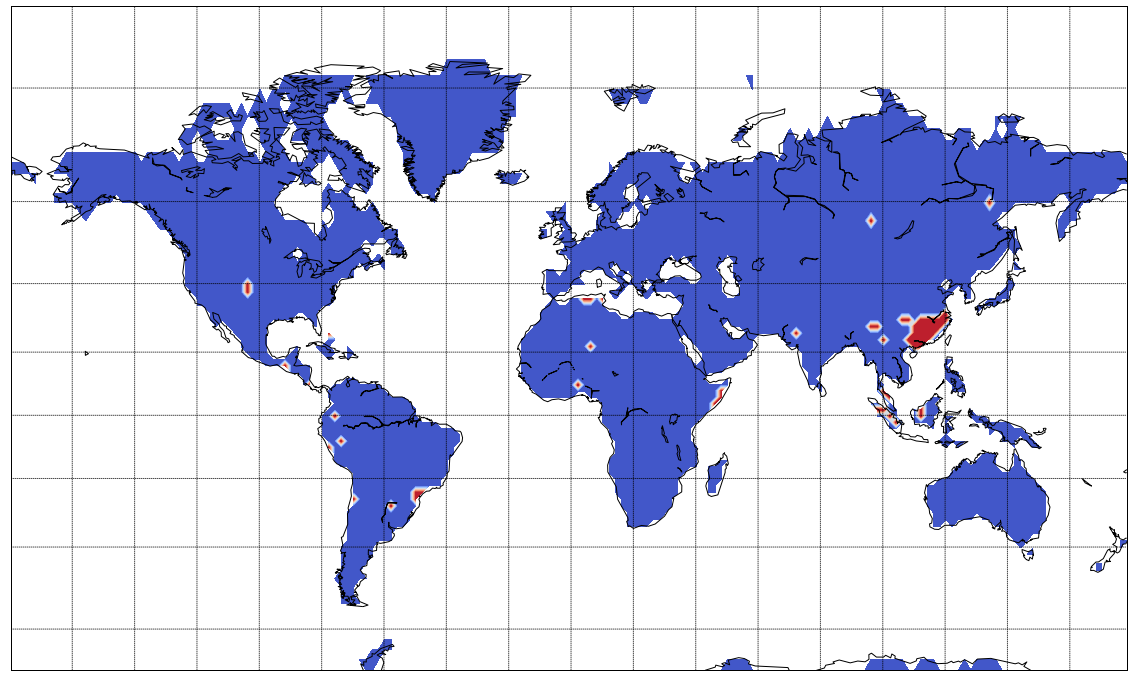

In [45]:
#plt.figure(figsize=(30,15))

lon  = lon1_soil
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_soil.min(), \
  urcrnrlon=lon1_soil.max(),llcrnrlat=lat_soil.min()+20,urcrnrlat=lat_soil.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon1_soil,lat_soil)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
#plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
#plt.colorbar();
#plt.savefig("SOIL_EOF{}.png".format(pc))